# Embedding based Drift
This notebook trains a RoBERTa baseline, detects **embedding drift** (MMD, Energy, PCA→KS, Centroid, Fréchet) with a **CUSUM** alarm, and adapts via **LoRA**. 

In [1]:
# Installing Libraries
import os, sys, subprocess, time, urllib.request

CORE = [
    "transformers==4.44.2",
    "datasets==2.19.0",
    "accelerate==0.33.0", 
    "peft==0.12.0",
    "evaluate==0.4.1",     
    "sentencepiece>=0.1.99",
    "bitsandbytes==0.43.1",
]

#checking if internet is accessible
def net_ok(url="https://pypi.org/simple/"):
    try:
        with urllib.request.urlopen(url, timeout=5) as r: return r.status == 200
    except Exception: return False

def pip_install(pkgs, tries=5, wait=5):
    cmd = [sys.executable, "-m", "pip", "install", "-q", "-U", "--upgrade-strategy", "only-if-needed"] + pkgs
    for i in range(1, tries+1):
        try:
            print(f"[pip] attempt {i}/{tries}: {' '.join(pkgs)}")
            subprocess.check_call(cmd); return True
        except subprocess.CalledProcessError as e:
            print(f"[pip] failed: {e} (retry in {wait}s)"); time.sleep(wait)
    return False

os.environ["PIP_DEFAULT_TIMEOUT"] = "180"
print("Internet reachable:", net_ok())
ok = pip_install(CORE)
print("Core installs succeeded:", ok)

# Show versions
def ver(m):
    try:
        mod = __import__(m); return getattr(mod, "__version__", "n/a")
    except Exception: return "missing"
for m in ["transformers","datasets","accelerate","peft","evaluate","sentencepiece","numpy","scipy","sklearn"]:
    print(f"{m:12s} -> {ver(m)}")

import torch, transformers, datasets, peft, accelerate
print("PyTorch:", torch.__version__, "| CUDA available:", torch.cuda.is_available())
print("Transformers:", transformers.__version__, "| PEFT:", peft.__version__, "| Accelerate:", accelerate.__version__)

Internet reachable: True
[pip] attempt 1/5: transformers==4.44.2 datasets==2.19.0 accelerate==0.33.0 peft==0.12.0 evaluate==0.4.1 sentencepiece>=0.1.99 bitsandbytes==0.43.1
Core installs succeeded: True
transformers -> 4.44.2
datasets     -> 2.19.0
accelerate   -> 0.33.0
peft         -> 0.12.0


2025-12-04 12:24:23.121731: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764851063.146856    8135 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764851063.154640    8135 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


evaluate     -> 0.4.1
sentencepiece -> 0.2.1
numpy        -> 1.26.4
scipy        -> 1.15.3
sklearn      -> 1.2.2
PyTorch: 2.6.0+cu124 | CUDA available: True
Transformers: 4.44.2 | PEFT: 0.12.0 | Accelerate: 0.33.0


In [2]:
# Cell 1 — Importing libraries
import os, gc, random, warnings, numpy as np, pandas as pd
from datasets import load_dataset, Dataset
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          DataCollatorWithPadding, TrainingArguments, Trainer)
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score
from scipy.spatial.distance import cdist
from scipy.stats import ks_2samp
import torch

import gc, torch
import numpy as np
from sklearn.decomposition import PCA
from transformers import AutoModel


import numpy as np
from scipy.spatial.distance import cdist
from scipy.stats import ks_2samp


warnings.filterwarnings("ignore")

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
USE_BF16 = torch.cuda.is_available() and torch.cuda.is_bf16_supported()
USE_FP16 = torch.cuda.is_available() and not USE_BF16

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if DEVICE == "cuda":
    torch.cuda.manual_seed_all(SEED)

# for saving models
WORK = "/kaggle/working"
ART  = f"{WORK}/artifacts"; os.makedirs(ART, exist_ok=True)

# using RoBERTa base as a baseline model
MODEL_NAME = "roberta-base"
MAX_LEN = 256
BATCH   = 32


# rechecking wheather the notebook is using GPU OR CPU and also checking precisions
print("Device:", DEVICE, "| bf16:", USE_BF16, "| fp16:", USE_FP16)

Device: cuda | bf16: True | fp16: False


# Dataset

In [3]:
# loading the Yelp Review Full dataset from HuggingFace
yelp = load_dataset("yelp_review_full")

print('Dataset uploaded')

Dataset uploaded


In [4]:
# Converting the 5 class labels into binary labels
# mapping as (1,2) = 0 , (3) = -1 and (4, 5) = 1

def map_labels(e):
    y = e["label"]
    return {"text": e["text"], "label_bin": 0 if y<=1 else (1 if y>=3 else -1)}

proc = yelp.map(map_labels, remove_columns=yelp["train"].column_names)

# removing the neutral class (label bin: -1)
proc = proc.filter(lambda x: x["label_bin"] != -1)
print('Converted 5 class labels in to Binary labels')

Converted 5 class labels in to Binary labels


In [5]:
# T0 reference block and window

N0  = 120_000 # examples for baseline
WIN = 25_000 # 25k per window

# extracting the training split and basic lists
train_all = proc["train"]
texts  = train_all["text"]
labels = train_all["label_bin"]

# Splitting into T0 (baseline) and the rest (future stream)
t0_texts, t0_labels = texts[:N0], labels[:N0]    # elements from index 0 to 119,999 (first 120k)
rest_texts, rest_labels = texts[N0:], labels[N0:]   # elements from index 120,000 to the end

# Creating streaming windows from the rest
windows = [(rest_texts[i:i+WIN], rest_labels[i:i+WIN]) for i in range(0, len(rest_texts), WIN)]
windows = windows[:8] # limited to 8 to make it time efficent


print('Text in T0:', len(t0_texts))
print('Windows:', len(windows))


Text in T0: 120000
Windows: 120000


In [6]:
# Try to use the evaluate library (huggingface), otherwise fall back to sklearn

try:
    import evaluate
    HAVE_EVAL = True
    metric_f1 = evaluate.load("f1")
except Exception:
    HAVE_EVAL = False
    metric_f1 = None
print("Have evaluate:", HAVE_EVAL)

Have evaluate: True


In [7]:
# loading the tokenizer: roberta base 
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)


# helper function to tokenize batches
def tok(batch):
    return tokenizer(batch["text"], truncation=True, max_length=MAX_LEN) # using truncation true to cutoff long texts


In [8]:
# Building a DataFrame for T0
t0_df = pd.DataFrame({"text": t0_texts, "label": t0_labels})
t0_df["label"] = t0_df["label"].astype("int64")


# converting the DataFrame into a HuggingFace Dataset object (needed for Trainer).
t0_ds = Dataset.from_pandas(t0_df, preserve_index=False).shuffle(seed=SEED)

# splitting the dataset 90/10
split = t0_ds.train_test_split(test_size=0.1, seed=SEED)
t0_train, t0_val = split["train"], split["test"]


# Tokenize the train and validation sets (The model cannot read raw text; it needs token IDs.)
t0_train = t0_train.map(tok, batched=True)
t0_val   = t0_val.map(tok, batched=True)

# renaming columns for trainer
t0_train = t0_train.rename_column("label", "labels")
t0_val   = t0_val.rename_column("label", "labels")


# using only the relevent columns
def keep(ds):
    cols = [c for c in ["input_ids","attention_mask","labels","token_type_ids"] if c in ds.column_names]
    return ds.remove_columns([c for c in ds.column_names if c not in cols])
t0_train = keep(t0_train); t0_val = keep(t0_val)


Map:   0%|          | 0/108000 [00:00<?, ? examples/s]

Map:   0%|          | 0/12000 [00:00<?, ? examples/s]

In [9]:
# Loading pretrained model for binary classification
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2).to(DEVICE)

# matrix to compute f1
def compute_metrics(eval_pred):
    logits, labels = (eval_pred if isinstance(eval_pred, tuple)
                      else (eval_pred.predictions, eval_pred.label_ids))
    import numpy as _np
    if not hasattr(logits, "shape"): logits = _np.asarray(logits)
    preds = logits.argmax(-1)
    if HAVE_EVAL:
        return {"f1": metric_f1.compute(predictions=preds, references=labels, average="macro")["f1"]}
    else:
        return {"f1": f1_score(labels, preds, average="macro")}

# defining training parameters
args = TrainingArguments(
    output_dir=f"{ART}/baseline",
    learning_rate=2e-5,
    per_device_train_batch_size=BATCH,
    per_device_eval_batch_size=BATCH,
    num_train_epochs=2,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    seed=SEED,
    report_to=[],
    save_total_limit=2,
    bf16=USE_BF16,
    fp16=USE_FP16,
    dataloader_pin_memory=True,
)

# creating trainer
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=t0_train,
    eval_dataset=t0_val,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer),
    compute_metrics=compute_metrics
)

# training the baseline
trainer.train()


trainer.save_model(f"{ART}/baseline/model")
tokenizer.save_pretrained(f"{ART}/baseline/tokenizer")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,0.087400,0.089650,0.970140
2,0.055100,0.095185,0.973798


('/kaggle/working/artifacts/baseline/tokenizer/tokenizer_config.json',
 '/kaggle/working/artifacts/baseline/tokenizer/special_tokens_map.json',
 '/kaggle/working/artifacts/baseline/tokenizer/vocab.json',
 '/kaggle/working/artifacts/baseline/tokenizer/merges.txt',
 '/kaggle/working/artifacts/baseline/tokenizer/added_tokens.json',
 '/kaggle/working/artifacts/baseline/tokenizer/tokenizer.json')

In [10]:
# Evaluating the model on Validation set

metrics = trainer.evaluate()

print('Evaluation F1:', metrics["eval_f1"])
print('Evaluation losee' , metrics["eval_loss"])


Evaluation F1: 0.9737978584844171
Evaluation losee 0.09518510103225708


# **Build the Reference Embeddings (R0) for Drift Detection**

In [12]:
# Parameters for reference embedding
R0_N = 12000
EMB_BATCH = 128
MAX_LEN_EMB = min(256, 256)

# Load a lighter encoder (no classification head) in mixed precision
# I use a separate encoder instead of the classification head 
# because drift detection should operate in the semantic embedding space, not the classifier’s output space.

encoder = AutoModel.from_pretrained(
    MODEL_NAME,
    torch_dtype=(
        torch.bfloat16 if (torch.cuda.is_available() and torch.cuda.is_bf16_supported()) else
        (torch.float16 if torch.cuda.is_available() else torch.float32)
    )
).to(DEVICE)
encoder.eval()
torch.set_grad_enabled(False)


# using no gradients so execution ll be fast, memory efficent and safe
@torch.no_grad()
def get_embeddings(texts, batch_size=EMB_BATCH):
    embs = []
    use_amp = torch.cuda.is_available()
    amp_dtype = torch.bfloat16 if (use_amp and torch.cuda.is_bf16_supported()) else (torch.float16 if use_amp else None)

    # iteratve over texts in small batches
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        
        # Tokenize the batch (pad, truncate, and return PyTorch tensors).
        enc = tokenizer(
            batch_texts,
            padding=True, truncation=True,
            max_length=MAX_LEN_EMB,
            return_tensors="pt"
        )
        # Move tokenized inputs to the device (GPU/CPU).
        enc = {k: v.to(DEVICE, non_blocking=True) for k, v in enc.items()}


        # Forward pass with mixed precision(Text → Tokens → Transformer → Numeric outputs)
        if amp_dtype is not None:
            with torch.autocast(device_type="cuda", dtype=amp_dtype):
                out = encoder(**enc, return_dict=True)  # we only need last_hidden_state
        else:
            out = encoder(**enc, return_dict=True)

        # Take the CLS token embedding: take the first token of every sentence (CLS token).
        # That token is treated as the summary of the entire sentence.
        cls = out.last_hidden_state[:, 0, :].detach().to("cpu", dtype=torch.float32).numpy()
        embs.append(cls)

        # Cleaning up to free GPU memory after each batch.
        del enc, out, cls
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        gc.collect()

    return np.vstack(embs)


#  Compute reference embeddings R0 from the first R0_N T0 texts
print('Computing the Reference Embeddings for R0')
R0 = get_embeddings(t0_texts[:R0_N])
np.save(f"{ART}/R0.npy", R0)

# project embeddings into a 50-dimensional PCA space
print('Fitting PCA model in 50 Dimensions')
pca = PCA(n_components=50).fit(R0)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Computing the Reference Embeddings for R0
Fitting PCA model in 50 Dimensions


In [ ]:
# Re-enable gradients for training steps (LoRA needs this)
import gc, torch
torch.set_grad_enabled(True)

# clearing caches to free up gpu
if torch.cuda.is_available():
    torch.cuda.empty_cache()
gc.collect()


# **Drift metrics & calibration**

In [14]:
# ---------------------------------------------------------
# Drift Metrics
# Defines 5 different ways to measure how different two embedding sets are. R0 vs Zt
# ---------------------------------------------------------


# 1) MMD with RBF kernel
# It detects drift even when means and variances are identical, because kernel functions capture more complex structure.
def mmd_rbf(x,y,sigma=None):
    if sigma is None:
        samp = np.vstack([
            x[np.random.randint(0,len(x),min(2000,len(x)))],
            y[np.random.randint(0,len(y),min(2000,len(y)))]
        ])
        d = cdist(samp,samp,'sqeuclidean')
        med = np.median(d[d>0]) if np.any(d>0) else 1.0
        sigma = max((0.5*med)**0.5, 1e-6)
    def k(a,b): return np.exp(-cdist(a,b,'sqeuclidean')/(2*sigma**2)) # RBF Kernal: converts distances between points into similarities between 0 and 1.
        Kxx=k(x,x); np.fill_diagonal(Kxx,0) # pairwise kernel values within x
        Kyy=k(y,y); np.fill_diagonal(Kyy,0) # pairwise kernel values within y
        Kxy=k(x,y); m=len(x); n=len(y) # pairwise kernel values between x and y
    return Kxx.sum()/(m*(m-1)) + Kyy.sum()/(n*(n-1)) - 2*Kxy.mean()

# 2) Energy distance: Good at detecting large geometric shifts in embedding space.
def energy_distance(x,y):
    xy=cdist(x,y).mean(); xx=cdist(x,x).mean(); yy=cdist(y,y).mean()
    return 2*xy - xx - yy

# 3) PCA-KS: run KS test on each PCA component and average the statistics.def pca_ks(x,y,pca_model,top_u=20):
def pca_ks(x,y,pca_model,top_u=20):
    X=pca_model.transform(x); Y=pca_model.transform(y); u=min(top_u, X.shape[1])
    return float(np.mean([ks_2samp(X[:,j],Y[:,j]).statistic for j in range(u)]))
    
# 4) Centroid shift: distance between mean embeddings.
def centroid_shift(x,y): 
    return float(np.linalg.norm(x.mean(0)-y.mean(0)))

# 5) Fréchet-like distance (similar to FID): compares means and covariances.
# It measures mean difference + shape difference between embeddings.
def frechet_distance(x,y):
    mu1, mu2 = x.mean(0), y.mean(0)
    s1, s2   = np.cov(x,rowvar=False), np.cov(y,rowvar=False)
    diff     = mu1 - mu2
    u,s,vh   = np.linalg.svd(s1 @ s2)
    sp       = u @ np.diag(np.sqrt(np.clip(s,1e-12,None))) @ vh
    return float(diff.dot(diff) + np.trace(s1 + s2 - 2*sp))



# ---------------------------------------------------------
# Calibration: estimate mean and std of each metric under "no drift"
# by comparing random splits of R0 against itself.
# ---------------------------------------------------------



# calibrates what “normal variation” looks like when there is no drift.
def calibrate(R0,pca_model,B=30,n=2000):
    mmds=[]; eds=[]; pks=[]; cents=[]; fids=[]
    N=len(R0); n=min(n,N//2)
    for _ in range(B):
        i1=np.random.choice(N,n,replace=False); i2=np.random.choice(N,n,replace=False)
        X,Y=R0[i1],R0[i2]

        # Compute all five metrics for this bootstrap split
        mmds.append(mmd_rbf(X,Y))
        eds.append(energy_distance(X,Y))
        pks.append(pca_ks(X,Y,pca_model))
        cents.append(centroid_shift(X,Y))
        fids.append(frechet_distance(X,Y))
    
    # Helper to return (mean, std) for each metric's distribution.    
    def ms(a):
        a=np.array(a); 
        return (a.mean(), a.std()+1e-9)

    # Return calibration stats for each metric
    return {'mmd':ms(mmds),'ed':ms(eds),'pks':ms(pks),'cent':ms(cents),'fid':ms(fids)}


# Run calibration on the reference embeddings and PCA model.
calib = calibrate(R0, pca)
calib

{'mmd': (-0.00011473493953992517, 9.873768355539592e-05),
 'ed': (0.0008106801333549018, 0.00012690851274395253),
 'pks': (0.024901666666666666, 0.0014380397879176117),
 'cent': (0.019710322810957828, 0.002944920980706745),
 'fid': (0.02207799827329644, 0.0003933989792338717)}

In [15]:
# Fix PEFT trying to use bitsandbytes/Triton when we don't need it.
import sys, subprocess, importlib

# 1) Uninstall bitsandbytes (we're not using QLoRA here)
subprocess.call([sys.executable, "-m", "pip", "uninstall", "-y", "bitsandbytes"])

# 2) Tell PEFT to ignore bitsandbytes in this session (in case it was already imported)
import peft
import peft.tuners.lora.model as lora_model
lora_model.is_bnb_available = lambda: False

print("bitsandbytes removed; PEFT will not use bnb.")


Found existing installation: bitsandbytes 0.43.1
Uninstalling bitsandbytes-0.43.1:
  Successfully uninstalled bitsandbytes-0.43.1
bitsandbytes removed; PEFT will not use bnb.


In [16]:
# --- Disable bitsandbytes paths inside PEFT (avoid ModuleNotFoundError) ---
import os
os.environ["PEFT_DISABLE_BNB"] = "1"   # best-effort env flag (ignored by older peft, harmless otherwise)

import peft
import peft.import_utils as iu
from peft.tuners.lora import model as lora_model

# Force all bnb checks to False
iu.is_bnb_available = lambda: False
iu.is_bnb_4bit_available = lambda: False
lora_model.is_bnb_available = lambda: False
lora_model.is_bnb_4bit_available = lambda: False

print("PEFT bnb paths disabled. Proceeding with standard LoRA (no bitsandbytes).")


PEFT bnb paths disabled. Proceeding with standard LoRA (no bitsandbytes).


In [17]:
# Simple z-score helper: standardize values using mean mu and std sd.
def zscore(s,mu,sd): 
    return (s-mu)/(sd+1e-9)   # tiny epsilon to avoid division by zero.

In [18]:
from peft import LoraConfig, get_peft_model, TaskType
try:
    from peft import PeftModel
    HAVE_PEFT_MODEL = True
except Exception:
    HAVE_PEFT_MODEL = False


# ---------------------------------------------------------
# CUSUM drift detector
# ---------------------------------------------------------
class Cusum:
    def __init__(self,kappa=0.5,h=3.0): # kappa acts as a bias or penalty.
        self.kappa=kappa
        self.h=h
        self.g=0.0
        
    def update(self,z): 
        # Update cumulative sum with (z - kappa), but do not let it go below 0.
        self.g=max(0.0, self.g+(z-self.kappa)) # z<kappa: CUSUM decreases, Z>kappa: CUSUM increases
        
        # Alarm if cumulative sum exceeds threshold h.
        return self.g>self.h

# Initialize CUSUM with chosen parameters.
cus = Cusum(0.5, 3.0)


In [19]:
# ---------------------------------------------------------
# LoRA configuration: target attention projections only.
# ---------------------------------------------------------

from peft import LoraConfig

def lora_cfg(model_name:str):
    
    name = model_name.lower()
    # Target ONLY attention projections to avoid issue in classifier head
    targets = ["query","key","value"]
    
    return LoraConfig(
        r=8, 
        lora_alpha=16, 
        lora_dropout=0.05,
        target_modules=targets,
        bias="none",
        task_type="SEQ_CLS"
    )

In [20]:
# ---------------------------------------------------------
# LoRA adaptation on a given set of texts and labels.
# ---------------------------------------------------------

def lora_adapt(texts, labels, epochs=1):
    # Load the baseline classifier as the base model.
    base = AutoModelForSequenceClassification.from_pretrained(f"{ART}/baseline/model", num_labels=2).to(DEVICE)
    
    # Wrap it with LoRA adapters.
    peftm= get_peft_model(base, lora_cfg(MODEL_NAME)).to(DEVICE)

    # Build a small dataset from the texts and labels.
    df = pd.DataFrame({"text":texts,"label":labels})
    ds = Dataset.from_pandas(df, preserve_index=False)

    # Tokenize the dataset.
    tok= ds.map(lambda b: tokenizer(b["text"], truncation=True, max_length=MAX_LEN), batched=True)
    tok= tok.rename_column("label","labels")
    tok= tok.remove_columns([c for c in tok.column_names if c not in ["input_ids","attention_mask","labels"]])

    # Training arguments for LoRA (small, fast adaptation).
    args=TrainingArguments(
        output_dir=f"{ART}/lora",
                           learning_rate=1e-3, 
                           per_device_train_batch_size=min(32, BATCH),
                           num_train_epochs=epochs, 
                           logging_steps=100, 
                           report_to=[], 
                           save_strategy="no",
                           bf16=USE_BF16, 
                           fp16=USE_FP16, 
                           seed=SEED, 
                           dataloader_pin_memory=True
    )

    # Trainer for LoRA adaptation.
    tr=Trainer(
        model=peftm, 
               args=args, 
               train_dataset=tok, 
               tokenizer=tokenizer, 
               data_collator=DataCollatorWithPadding(tokenizer)
    )

    tr.train()

    # Save adapters only (not the full model) for reuse.
    out=f"{ART}/adapters/last"; os.makedirs(out, exist_ok=True)
    peftm.save_pretrained(out)
    return out


In [21]:
# ---------------------------------------------------------
# Evaluation helper: compute Macro-F1 for a set of texts and labels
# using either the frozen baseline model or a LoRA-adapted model.
# ---------------------------------------------------------

@torch.no_grad()
def eval_f1(texts, labels, peft_path=None, batch_size=512):
    from peft import AutoPeftModelForSequenceClassification
    if peft_path:
        # If a LoRA adapter path is provided, load the PEFT model (baseline + adapters).
        m = AutoPeftModelForSequenceClassification.from_pretrained(peft_path).to(DEVICE)
        m.eval()
    else:
        m = AutoModelForSequenceClassification.from_pretrained(
            f"{ART}/baseline/model", num_labels=2
        ).to(DEVICE)
        m.eval()

   
    preds=[]
    # Process evaluation texts in batches.
    for i in range(0,len(texts),batch_size):
        enc = tokenizer(texts[i:i+batch_size], 
                        padding=True, 
                        truncation=True, 
                        max_length=MAX_LEN, 
                        return_tensors="pt")
        
        enc = {k: v.to(DEVICE) for k, v in enc.items()}
        logits = m(**enc).logits
        preds_batch = logits.argmax(-1).detach().cpu().tolist()
        preds += preds_batch

    # Compute Macro-F1 between true labels and predictions    
    return f1_score(list(labels), preds, average="macro")


In [22]:
# ---------------------------------------------------------
# Streaming loop over windows: drift detection + CUSUM + LoRA adaptation.
# ---------------------------------------------------------

results=[] 

hit=0


for wi,(wx,wy) in enumerate(windows, start=1):
    print(f"\n=== Window {wi} ===")

    # Sample a subset of texts from the window for drift estimation (up to 6000).
    idx = np.random.choice(len(wx), min(6000, len(wx)), replace=False)
    Zt  = get_embeddings([wx[i] for i in idx])


    # Compute all drift metrics against the reference embeddings R0.
    mmd=mmd_rbf(Zt,R0); 
    ed=energy_distance(Zt,R0); 
    pks=pca_ks(Zt,R0,pca); 
    cent=centroid_shift(Zt,R0)
    fid=frechet_distance(Zt,R0)
    
    
    # Convert each metric to a z-score using calibration statistics, then take the max.
    z  = max(
        zscore(mmd,*calib['mmd']), 
        zscore(ed,*calib['ed']), 
        zscore(pks,*calib['pks']), 
        zscore(cent,*calib['cent']), 
        zscore(fid,*calib['fid'])
    )

    # Update CUSUM with fused z-score.
    alarm = cus.update(z)
    
    # Count consecutive alarms (CUSUM > threshold).
    hit = hit+1 if alarm else 0 

    # Require two consecutive alarms before triggering adaptation.
    raised = hit>=2

    # Take a subset for evaluation F1 (first 1500 examples of this window).
    gx,gy = wx[:1500], wy[:1500]
    
    
    if raised:
        print("ALARM -> LoRA adapt")

        # Use a larger subset (first 4000 examples) for LoRA adaptation.
        ax,ay = wx[:4000], wy[:4000]

        # Evaluate frozen baseline model before adaptation.
        f1_frozen = eval_f1(gx,gy)

        # Run LoRA adaptation on current window data.
        peft_path = lora_adapt(ax,ay,epochs=1)

        # Evaluate LoRA-adapted model on the same eval subset.
        f1_lora   = eval_f1(gx,gy,peft_path)

        # Record results.
        results.append({"window":wi,
                        "z":float(z),
                        "alarm":True,
                        "f1_frozen":f1_frozen,
                        "f1_lora":f1_lora})

        
        # Reset consecutive hit counter after adaptation.
        hit=0
        
    else:
        # No adaptation: just evaluate the frozen baseline model.
        f1_frozen = eval_f1(gx,gy)
        results.append({"window":wi,
                        "z":float(z),
                        "alarm":False,
                        "f1_frozen":f1_frozen})


# Convert results to a DataFrame and save.
df = pd.DataFrame(results)
df.to_csv(f"{ART}/results.csv", index=False)
df.head()


=== Window 1 ===

=== Window 2 ===
ALARM -> LoRA adapt


Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Step,Training Loss



=== Window 3 ===

=== Window 4 ===
ALARM -> LoRA adapt


Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Step,Training Loss



=== Window 5 ===

=== Window 6 ===
ALARM -> LoRA adapt


Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Step,Training Loss



=== Window 7 ===

=== Window 8 ===
ALARM -> LoRA adapt


Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Step,Training Loss


,window,z,alarm,f1_frozen,f1_lora
0,1,138.888652,False,0.953350,NaN
1,2,79.327661,True,0.963957,0.971942
2,3,29.731930,False,0.967659,NaN
3,4,47.882075,True,0.969676,0.971702
4,5,40.253059,False,0.961059,NaN


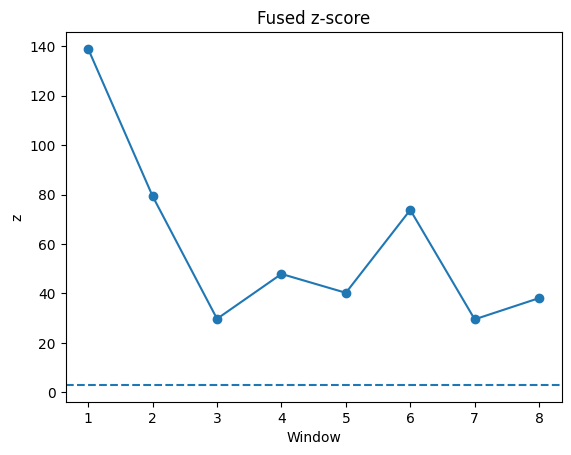

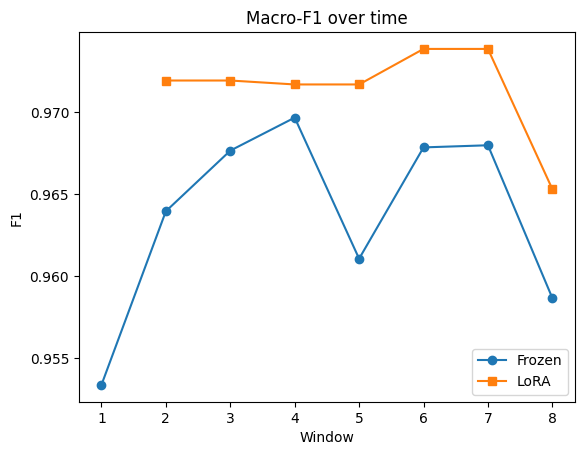

,window,z,alarm,f1_frozen,f1_lora
0,1,138.888652,False,0.953350,NaN
1,2,79.327661,True,0.963957,0.971942
2,3,29.731930,False,0.967659,NaN
3,4,47.882075,True,0.969676,0.971702
4,5,40.253059,False,0.961059,NaN
5,6,73.776388,True,0.967857,0.973872
6,7,29.525563,False,0.967987,NaN
7,8,38.112211,True,0.958656,0.965309


In [23]:
# Plotting
import matplotlib.pyplot as plt

plt.figure()
plt.plot(df["window"], df["z"], marker='o')
plt.axhline(y=3.0, linestyle='--')
plt.title("Fused z-score")
plt.xlabel("Window"); plt.ylabel("z")
plt.show()

plt.figure()
plt.plot(df["window"], df["f1_frozen"], marker='o', label="Frozen")
if "f1_lora" in df.columns:
    plt.plot(df["window"], df["f1_lora"].fillna(method="ffill"), marker='s', label="LoRA")
plt.title("Macro-F1 over time"); plt.xlabel("Window"); plt.ylabel("F1"); plt.legend(); plt.show()

df